# Day 5: Backtesting & Mathematical Tools

## Backtesting
* Frank Smietana, [backtesting systematic trading strategies in python: considerations and open source frameworks](https://www.quantstart.com/articles/backtesting-systematic-trading-strategies-in-python-considerations-and-open-source-frameworks)
    * PyAlgoTrade: http://gbeced.github.io/pyalgotrade/
    * bt 
    * **Backtrader**
    * pysystemtrade
    * Zipline
    * QSTrader

### Package: backtrader
* Tutorial: https://www.backtrader.com/docu/introduction.html
    * Type the following instruction to install backtrader:
    
        ```python
        pip install backtrader
        ```
    * Data set: [S&P500 Index](https://www.csie.ntu.edu.tw/~d00922011/python/data/^GSPC.csv) (You should use the data of E-Mini S&P 500! See [E-mini S&P 500 Futures Quotes](https://www.cmegroup.com/cn-t/trading/equity-index/us-index/e-mini-sandp500.html).)
        
* Overview
    * Data feed: financial time series (date, open, high, low, close, volume)
    * Strategy
    * Broker (executor)
    * Indicator (optional)
  
* Quick starter: https://www.backtrader.com/docu/quickstart/quickstart.html
    

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import backtrader as bt
import datetime

cerebro = bt.Cerebro()
data = bt.feeds.GenericCSVData(dataname = "./^GSPC.csv",
                               dtformat = ('%Y-%m-%d'),
                               datetime = 0,
                               open = 1,
                               high = 2,
                               low = 3,
                               close = 4,
                               volume = 6)
cerebro.adddata(data)

In [2]:
class MyStrategy(bt.Strategy):

    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):

        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add MovingAverageSimple indicators
        self.sma5 = bt.indicators.SimpleMovingAverage(self.datas[-1], period = 5)
        self.sma10 = bt.indicators.SimpleMovingAverage(self.datas[-1], period = 10)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Rejected]:
            self.log('Order Canceled/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    
    def next(self):
        
        self.log('close price, %.2f' % self.dataclose[0])

        if self.order:
            return
        
        if self.sma5 > self.sma10 and self.data.close[0] < self.data.close[-1]:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.order = self.buy()
            
        elif self.data.close[0] < self.data.close[-1]:
            self.log('CLOSE LONG POSITION, %.2f' % self.dataclose[0])
            self.order = self.close()

cerebro.addstrategy(MyStrategy)

0

In [3]:
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission = 0.0015)
cerebro.addsizer(bt.sizers.SizerFix, stake = 2)

In [4]:
print("Initial portfolio value:", cerebro.broker.getvalue())
cerebro.run()
print("Final portfolio value:", cerebro.broker.getvalue())

Initial portfolio value: 100000.0
2015-08-01, close price, 1972.18
2015-08-01, BUY CREATE, 1972.18
2015-09-01, BUY EXECUTED, Price: 1970.09, Cost: 3940.18, Comm 5.91
2015-09-01, close price, 1920.03
2015-09-01, CLOSE LONG POSITION, 1920.03
2015-10-01, SELL EXECUTED, Price: 1919.65, Cost: 3940.18, Comm 5.76
2015-10-01, OPERATION PROFIT, GROSS -100.88, NET -112.55
2015-10-01, close price, 2079.36
2015-11-01, close price, 2080.41
2015-12-01, close price, 2043.94
2015-12-01, CLOSE LONG POSITION, 2043.94
2016-01-01, close price, 1940.24
2016-01-01, CLOSE LONG POSITION, 1940.24
2016-02-01, close price, 1932.23
2016-02-01, CLOSE LONG POSITION, 1932.23
2016-03-01, close price, 2059.74
2016-04-01, close price, 2065.30
2016-05-01, close price, 2096.95
2016-06-01, close price, 2098.86
2016-07-01, close price, 2173.60
2016-08-01, close price, 2170.95
2016-08-01, BUY CREATE, 2170.95
2016-09-01, BUY EXECUTED, Price: 2171.33, Cost: 4342.66, Comm 6.51
2016-09-01, close price, 2168.27
2016-09-01, BUY C

#### Complete program
* Try https://www.csie.ntu.edu.tw/~d00922011/python/program/bt_on_dj.py.

## Numerical pacakge: NumPy

* Reference:
    * https://docs.scipy.org/doc/numpy/user/
    * Cheat sheet: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf
* **Vectorization**: different from python lists, similar to MATLAB
* Array creations
* Data types: same type in one array
    * dtype: int8, int16, ..., float16, float32, ..., complex64, bool, unicode_
    * numpy.astype()
* Array operations
* Array properties

In [5]:
import matplotlib.pyplot as plt

### Vectorization

In [6]:
# list

x = [1, 2, 3]
y = [4, 5, 6]
x + y

[1, 2, 3, 4, 5, 6]

In [7]:
print(type(x))

<class 'list'>


In [8]:
import numpy as np

x = np.array(x)
print(type(x))

<class 'numpy.ndarray'>


In [9]:
y = np.array(y)
x + y

array([5, 7, 9])

In [10]:
# list: *

s = "N"
print(s * 10)

NNNNNNNNNN


In [11]:
# numpy: *

salary = np.array([10, 20, 30])
hours = np.array([100, 50, 10])
payment = salary * hours
print(payment)

[1000 1000  300]


### Array creation
* numpy.array()
* numpy.arange()
* numpy.linspace()
* numpy.ones()
* numpy.zeros()
* numpy.eye()
* numpy.diag()
* numpy.random.rand()
* numpy.random.randn()
* numpy.random.randint()

In [12]:
xdata = np.linspace(0, 10, 11)
print(xdata)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [13]:
ydata = np.arange(0, 1, 0.1, dtype = "float64")
print(ydata)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [14]:
M = np.zeros([3, 3])
print(M)

M[1, 1] = 5
print(M)

M[2, :] = [10, 20, 30]
print(M)

M[:, 2] = [100, 200, 300]
print(M)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 5. 0.]
 [0. 0. 0.]]
[[ 0.  0.  0.]
 [ 0.  5.  0.]
 [10. 20. 30.]]
[[  0.   0. 100.]
 [  0.   5. 200.]
 [ 10.  20. 300.]]


In [15]:
N = M.reshape(9, 1)
print(N)

[[  0.]
 [  0.]
 [100.]
 [  0.]
 [  5.]
 [200.]
 [ 10.]
 [ 20.]
 [300.]]


### Array operations
* numpy.reshape()
* numpy.array_equal()
* numpy.prod()
* numpy.sum()
* numpy.mean()
* numpy.unique()
* numpy.concatenate()
* numpy.all()
* numpy.any()
* numpy.sort()

In [16]:
A = np.random.randint(low = -5, high = 5, size = (3, 3))
print(A)

[[-2  4  2]
 [ 0  4 -2]
 [-1  4  1]]


In [17]:
print(np.sum(A))
print(np.sum(A, axis = 0)) # by cols (row major)
print(np.sum(A, axis = 1)) # by rows (column major)

10
[-3 12  1]
[4 2 4]


In [18]:
print(np.mean(A, axis = 0))

[-1.          4.          0.33333333]


In [19]:
print(np.mean(A, axis = 1))

[1.33333333 0.66666667 1.33333333]


#### Exercise: estimating $\pi$ by MC using numpy

In [20]:
import numpy as np

N = 100000
m = 0
for _ in range(N):
    x = np.random.rand()
    y = np.random.rand()
    if x ** 2 + y ** 2 < 1:
        m += 1
        
print(4 * m / N)

3.1522


In [21]:
x = np.random.rand(1, N)
y = np.random.rand(1, N)
print(4 * np.sum(x ** 2 + y ** 2 < 1) / N)

3.14424


### Matrix computation
* numpy.ndim
* numpy.shape
* numpy.size
* numpy.T
* numpy.ravel()
* numpy.where()
* np.linalg.dot()
* np.linalg.det()
* np.linalg.inv()

In [22]:
A = np.random.randint(-3, 3, size = (3, 3))
print(A)
print(A.shape)
print(A.ravel()) # return a contiguous flattened array; see https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html
print(A.T)

[[ 0  0  1]
 [-3 -1  0]
 [ 1  0  0]]
(3, 3)
[ 0  0  1 -3 -1  0  1  0  0]
[[ 0 -3  1]
 [ 0 -1  0]
 [ 1  0  0]]


#### Inner product

In [23]:
u = np.array([[1], [2], [3]])
v = np.array([[4], [5], [6]])
print(u)
print(v)

[[1]
 [2]
 [3]]
[[4]
 [5]
 [6]]


In [24]:
u = u.T
print(u.dot(v))

[[32]]


In [25]:
x = np.random.randint(-10, 10, size = (3, 1))
print(x)

[[ 7]
 [ 9]
 [-8]]


In [26]:
y =  A.dot(x)
print(y)

[[ -8]
 [-30]
 [  7]]


#### Inverse matrix
* It is common to solve a `set of linear equations` like:
$$A x = y,$$
where $A$ describes the properties of the system (represented by coefficients) and $y$ is the response (say the `initial condition` or the `boundary condition`).
* For any square matrix $A$, $A$ is `invertible` iff $A A^{-1} = A^{-1} A = I$ where $I$ is the `identity`.
    * $A$ is invertible if $\det A \neq 0$.

In [27]:
print(np.linalg.det(A))

1.0


In [28]:
iA = np.linalg.inv(A)
print(iA)

[[-0. -0.  1.]
 [-0. -1. -3.]
 [ 1.  0.  0.]]


In [29]:
print(A.dot(iA))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [30]:
print(iA.dot(A))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


## Package: SciPy
* Tutorial: http://scipy-lectures.org/intro/scipy.html
    * Linear algebra: ``scipy.linalg`` (provides standard linear algebra operations, relying on an underlying efficient implementation (BLAS, LAPACK).)
        * Documentation: https://docs.scipy.org/doc/scipy/reference/linalg.html#module-scipy.linalg
        * More about linear algebra: https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab
    * Interpolation: ``scipy.interpolate``
    * Optimization and fit: ``scipy.optimize``
    * Statistics and random numbers: ``scipy.stats``
    * Numerical integration: ``scipy.integrate``
    * And more!!!
* Official documentation: https://docs.scipy.org/doc/scipy/reference/tutorial/
* Cheat sheet: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_SciPy_Cheat_Sheet_Linear_Algebra.pdf

In [31]:
import scipy

### Linear Algebra

#### Matrix decomposition
* LU factorization
* QR factorization
* Cholesky factorization
* Eigenvalue problem
* Singular value decomposition (SVD)

In [32]:
import scipy.linalg

P, L, U = scipy.linalg.lu(A)
print(P) # permutation matrix
print(L) # lower triangular matrix
print(U) # upper triangular matrix

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[ 1.          0.          0.        ]
 [-0.33333333  1.          0.        ]
 [-0.         -0.          1.        ]]
[[-3.         -1.          0.        ]
 [ 0.         -0.33333333  0.        ]
 [ 0.          0.          1.        ]]


In [33]:
Q, R = scipy.linalg.qr(A)
print(Q)
print(R)

[[ 0.00000000e+00 -2.77555756e-16 -1.00000000e+00]
 [ 9.48683298e-01 -3.16227766e-01  0.00000000e+00]
 [-3.16227766e-01 -9.48683298e-01  1.66533454e-16]]
[[-3.16227766e+00 -9.48683298e-01  0.00000000e+00]
 [ 0.00000000e+00  3.16227766e-01 -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]


In [34]:
rho = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
      ])

L = scipy.linalg.cholesky(rho)
print(L)
print(L.T.dot(L))

[[ 1.84390889 -1.4913969  -1.08465229]
 [ 0.          1.80989925 -0.06500199]
 [ 0.          0.          0.26325682]]
[[ 3.4  -2.75 -2.  ]
 [-2.75  5.5   1.5 ]
 [-2.    1.5   1.25]]


In [35]:
A = A.dot(A.T)
D, V = scipy.linalg.eig(A)
print(D) # eigenvalues
print(V) # eigenspace
print(scipy.linalg.norm(V[0])) # check the norm of one eigenvector

[ 0.09167309+0.j 10.90832691+0.j  1.        +0.j]
[[ 0.          0.          1.        ]
 [-0.28978415 -0.95709203  0.        ]
 [-0.95709203  0.28978415  0.        ]]
1.0


In [36]:
U, S, V = scipy.linalg.svd(A)
print(S) # singular values

[10.90832691  1.          0.09167309]


#### Special matrices 
* https://docs.scipy.org/doc/scipy-0.14.0/reference/linalg.html#special-matrices

In [37]:
from scipy.linalg import block_diag
A = [[1, 0],
     [0, 1]]
B = [[3, 4, 5],
     [6, 7, 8]]
C = [[7]]

print(block_diag(A, B, C))

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 3 4 5 0]
 [0 0 6 7 8 0]
 [0 0 0 0 0 7]]


### Interpolation

In [38]:
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10) * 5 - 1) * 1e-1
measures = np.sin(2 * np.pi * measured_time) + noise

In [39]:
from scipy.interpolate import interp1d

linear_interp = interp1d(measured_time, measures)

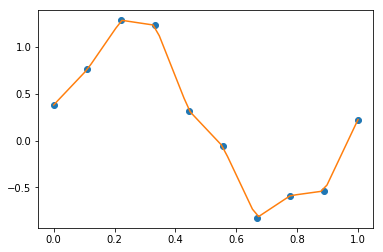

In [40]:
interpolation_time = np.linspace(0, 1, 50)
linear_results = linear_interp(interpolation_time)

plt.figure()
plt.plot(measured_time, measures, 'o')
plt.plot(interpolation_time, linear_results)

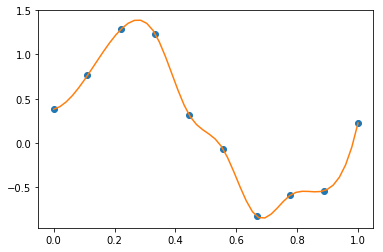

In [41]:
cubic_interp = interp1d(measured_time, measures, kind ='cubic') # cubic spline
cubic_results = cubic_interp(interpolation_time)

plt.figure()
plt.plot(measured_time, measures, 'o')
plt.plot(interpolation_time, cubic_results)

### Optimization
* https://web.stanford.edu/~boyd/cvxbook/

In [42]:
from scipy import optimize

#### Curve fitting

In [43]:
x_data = np.linspace(-5, 5, num = 50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size = 50)

In [44]:
def test_func(x, a, b):
    return a * np.sin(b * x)

In [45]:
params, params_covariance = optimize.curve_fit(test_func, x_data, y_data, p0 = [2, 2])
print(params)

[2.64095464 1.46458041]


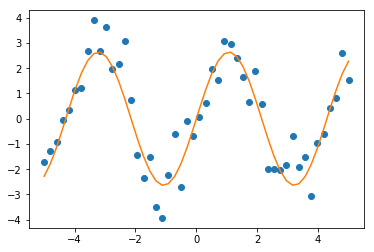

In [46]:
plt.figure()
plt.plot(x_data, y_data, 'o')
plt.plot(x_data, test_func(x_data, params[0], params[1]))

#### Finding the minimum of a scalar function
* Global minimum: a possible issue with this approach is that, if the function has local minima, the algorithm may find these local minima instead of the global minimum depending on the initial point $x_0$.

In [47]:
def f(x):
    return x**2 + 10*np.sin(x)

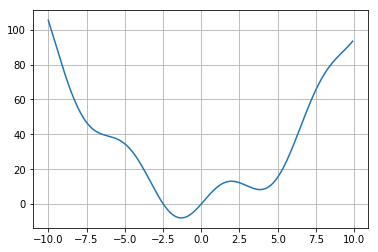

In [48]:
x = np.arange(-10, 10, 0.1)

plt.figure()
plt.plot(x, f(x))
plt.grid()
plt.show() 

In [49]:
result1 = optimize.minimize(f, x0 = 0)
print(result1)

      fun: -7.945823375615215
 hess_inv: array([[0.08589237]])
      jac: array([-1.1920929e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-1.30644012])


In [50]:
result2 = optimize.minimize(f, x0 = -7.5)
print(result2)

      fun: -7.945823375615282
 hess_inv: array([[0.08576896]])
      jac: array([-5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([-1.30644003])


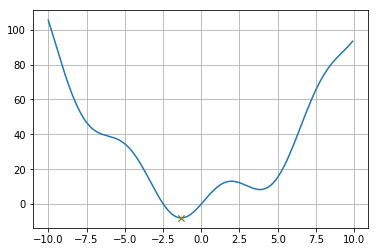

In [51]:
plt.figure()
plt.plot(x, f(x))
plt.plot(result1.x, f(result1.x), 'x') 
plt.plot(result2.x, f(result2.x), 'x') 
plt.grid()
plt.show() 

#### Finding a root

In [52]:
root1 = optimize.root(f, x0 = -7.5) # try another initial guess
print(root1)

    fjac: array([[-1.]])
     fun: array([-3.64153152e-14])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.99362846e-08])
       r: array([12.84594788])
  status: 1
 success: True
       x: array([-2.47948183])


In [53]:
root2 = optimize.root(f, x0 = 7.5) # try another initial guess
print(root2)

    fjac: array([[-1.]])
     fun: array([8.31558623])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 23
     qtf: array([-8.31558845])
       r: array([0.00695058])
  status: 5
 success: False
       x: array([3.8370742])


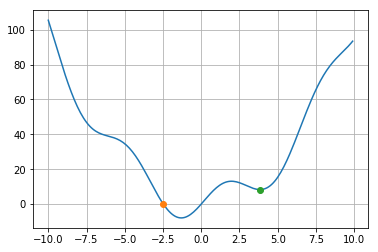

In [54]:
plt.figure()
plt.plot(x, f(x))
plt.plot(root1.x, f(root1.x), 'o')
plt.plot(root2.x, f(root2.x), 'o')
plt.grid()
plt.show() 

### Statistics

#### Random number generator for various probability distributions
* Uniform distribution
* Normal distribution
* $\chi_2$ distribution
* Poisson distriubtion

0.004694493446618548
0.006445814498652589


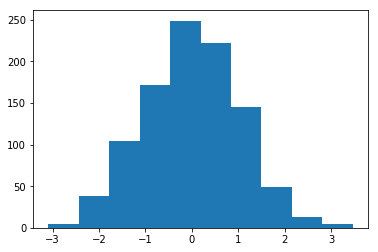

In [55]:
import scipy.stats

samples = np.random.normal(size = 1000)

plt.figure()
plt.hist(samples)

print(np.mean(samples))
print(np.median(samples))

In [56]:
print(scipy.stats.scoreatpercentile(samples, 5)) # 5% percentile
print(scipy.stats.scoreatpercentile(samples, 95)) # 95% percentile

-1.6614123837710686
1.6315815231110604


#### Hypothesis testing
* Kolmogorov-Smirnov test for goodness of fit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [73]:
print(scipy.stats.kstest(samples, 'norm')) 
# We cannot reject the null hypothesis, which states that the two distribution are identical.

KstestResult(statistic=0.023920654061844626, pvalue=0.6163405786192893)


### Application: Modern Portfolio Theory (MPT)
* [Markowitz](https://en.wikipedia.org/wiki/Harry_Markowitz) (1952): a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk.
    * Aka mean-variance analysis.
    * Won 1990 Nobel Memorial Prize in Economic Sciences.
    * https://www.math.ust.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf
    * [十分鐘讀懂理財投資學 - 什麼是最好的投資組合？](https://kopu.chat/2017/05/28/%E5%8D%81%E5%88%86%E9%90%98%E8%AE%80%E6%87%82%E7%90%86%E8%B2%A1%E6%8A%95%E8%B3%87%E5%AD%B8-%E4%BB%80%E9%BA%BC%E6%98%AF%E6%9C%80%E5%A5%BD%E7%9A%84%E6%8A%95%E8%B3%87%E7%B5%84%E5%90%88%EF%BC%9F/)
* Quadratic programming: https://en.wikipedia.org/wiki/Quadratic_programming
    $$\dfrac{1}{2}x^T Q x + p ^ T x$$
  subject to
    $$A x \preceq b.$$
    * Quadratic programming: https://cvxopt.org/examples/tutorial/qp.html
* References:
    * Thomas Wiecki, [the efficient frontier: Markowitz portfolio optimization in python](https://blog.quantopian.com/markowitz-portfolio-optimization-2/).
    * Convex optimization (CVXOPT): https://cvxopt.org/documentation/index.html
    * Polynomial regression: [numpy.polyfit](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.polyfit.html)
    * Data set: https://www.csie.ntu.edu.tw/~d00922011/python/data/L5_Data.csv

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

In [59]:
data = pd.read_csv('L5_Data.csv')
data.set_index("Date", inplace = True)
# del data["AAPL"]
data.head()
n_assets = data.shape[1]

In [60]:
return_rates = np.log(data / data.shift(1))

return_rates = return_rates[1:]
return_rates.head()

AAPL      MSFT      YHOO        DB       GLD
Date                                                        
2010-01-05  0.001727  0.000323  0.007574  0.018937 -0.000911
2010-01-06 -0.016034 -0.006156 -0.003488 -0.017436  0.016365
2010-01-07 -0.001850 -0.010454 -0.027755  0.011254 -0.006207
2010-01-08  0.006626  0.006873  0.000000  0.035496  0.004951
2010-01-11 -0.008861 -0.012802  0.002392 -0.005611  0.013201

Text(0,0.5,'Return rate (%)')

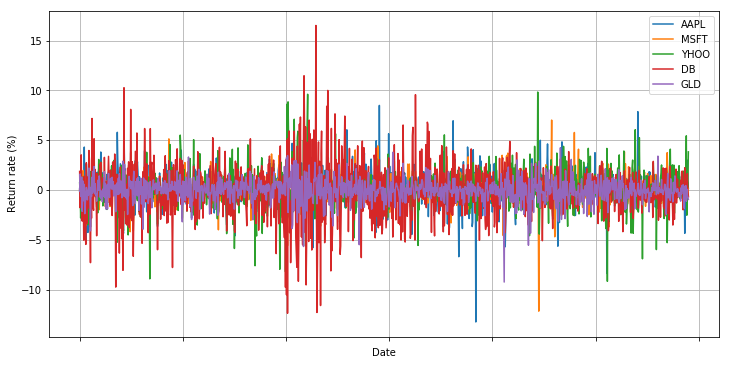

In [61]:
ax = return_rates.apply(lambda x : 100 * x).plot.line(grid = True, figsize = (12, 6))
ax.set_ylabel("Return rate (%)")

In [62]:
p = np.asmatrix(return_rates.mean() * 252).T # annualized
print(p)

[[ 0.26708004]
 [ 0.11450539]
 [ 0.19616463]
 [-0.12517423]
 [ 0.01605443]]


In [63]:
w = np.random.random(n_assets) # try a random weight vector
w /= np.sum(w) # normalization
print(w)

[0.28080675 0.11536743 0.09146337 0.2222825  0.29007995]


In [64]:
print(w * p)

[[0.08298297]]


In [65]:
C = return_rates.cov() * 252 # annualized
print(C)

          AAPL      MSFT      YHOO        DB       GLD
AAPL  0.072784  0.020459  0.023243  0.041027  0.005231
MSFT  0.020459  0.049402  0.024244  0.046089  0.002105
YHOO  0.023243  0.024244  0.093349  0.051538 -0.000864
DB    0.041027  0.046089  0.051538  0.177517  0.008777
GLD   0.005231  0.002105 -0.000864  0.008777  0.032406


In [66]:
sigma = np.sqrt(w.T.dot(C.dot(w)))
print(sigma)

0.1826658882401213


In [67]:
def generate_one_portfolio(r):
    
    w = np.random.random(r.shape[1])
    w /= np.sum(w)
    
    p = np.mean(r, axis = 0)
    C = r.cov()
    
    mu = w.T.dot(p) * 252
    sigma = np.sqrt(w.T.dot(C.dot(w)) * 252)
    
    return w, mu, sigma

In [68]:
n_portfolios = 3000
weights, means, stds = np.column_stack([generate_one_portfolio(return_rates) for _ in np.arange(n_portfolios)])
maxSharpe_idx = (means / stds).argmax()
print(weights[maxSharpe_idx])

[0.46919761 0.17223212 0.24780152 0.02186474 0.08890402]


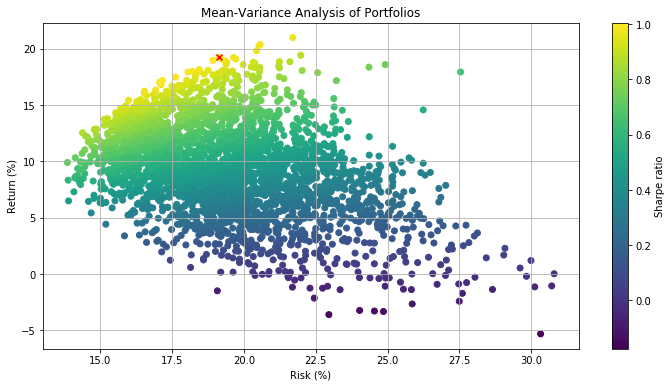

In [69]:
plt.figure(figsize = (12, 6))
plt.scatter(stds * 100, means * 100, c = means / stds, marker = 'o')
plt.colorbar(label = 'Sharpe ratio')
plt.scatter(stds[maxSharpe_idx] * 100, means[maxSharpe_idx] * 100, c = "r", marker = 'x')
plt.xlabel('Risk (%)')
plt.ylabel('Return (%)')
plt.title('Mean-Variance Analysis of Portfolios')
plt.grid()

In [70]:
import cvxopt as opt
from cvxopt import blas, solvers

def opt_portfolio(r):
    
    n = r.shape[1]
    solvers.options['show_progress'] = False
     
    N = 50
    risk_aversion_levels = [10 ** (2 * t / N - 2) for t in range(N)]
    
    p = opt.matrix(np.mean(r, axis = 0) * 252)
    S = opt.matrix(r.cov().values * 252)
    
    G = opt.matrix(-np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    weights = [solvers.qp(2 * S, -level * p, G, h, A, b)['x'] for level in risk_aversion_levels]
    
    returns = np.array([blas.dot(p, x) * 100 for x in weights])
    vols = np.array([np.sqrt(blas.dot(x, S * x)) * 100 for x in weights])
    
    # m = np.polyfit(returns, vols, 2)
    idx = (returns / vols).argmax()
    wt =  weights[idx]
    
    return idx, wt, returns, vols

In [71]:
opt_idx, opt_weight, opt_returns, opt_risks = opt_portfolio(return_rates)

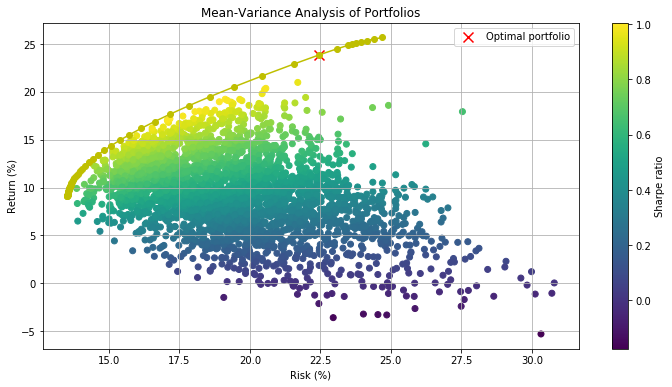

In [72]:
plt.figure(figsize = (12, 6))
plt.scatter(opt_risks[opt_idx], opt_returns[opt_idx], c = "r", marker = 'x', s = 100)
plt.legend(["Optimal portfolio"], loc = "best")
plt.scatter(stds * 100, means * 100, c = means / stds, marker = 'o')
plt.colorbar(label = 'Sharpe ratio')
plt.plot(opt_risks, opt_returns, 'y-o')
plt.xlabel('Risk (%)')
plt.ylabel('Return (%)')
plt.title('Mean-Variance Analysis of Portfolios')
plt.grid()

[ 6.78e-01]
[ 6.68e-02]
[ 2.55e-01]
[ 6.44e-09]
[ 1.93e-05]



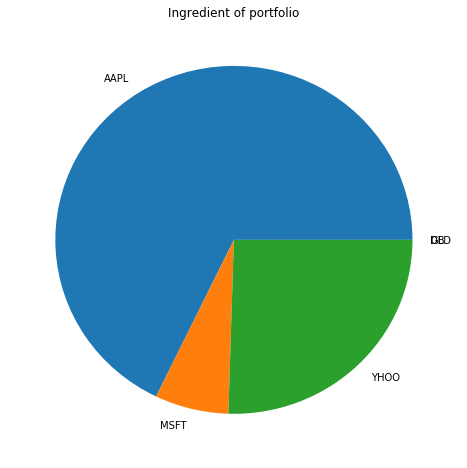

In [73]:
plt.figure(figsize = (8, 8))
plt.pie(opt_weight, labels = return_rates.columns.values)
plt.title("Ingredient of portfolio")
print(opt_weight)

In [74]:
return_rates["Equally-Weighted Portfolio"] = return_rates.dot(np.ones((n_assets, 1)) / n_assets)
return_rates["My Portfolio"] = return_rates.iloc[:, 0 : n_assets].dot(np.array(opt_weight))
return_rates.head()

AAPL      MSFT      YHOO        DB       GLD  \
Date                                                           
2010-01-05  0.001727  0.000323  0.007574  0.018937 -0.000911   
2010-01-06 -0.016034 -0.006156 -0.003488 -0.017436  0.016365   
2010-01-07 -0.001850 -0.010454 -0.027755  0.011254 -0.006207   
2010-01-08  0.006626  0.006873  0.000000  0.035496  0.004951   
2010-01-11 -0.008861 -0.012802  0.002392 -0.005611  0.013201   

            Equally-Weighted Portfolio  My Portfolio  
Date                                                  
2010-01-05                    0.005530      0.003124  
2010-01-06                   -0.005350     -0.012175  
2010-01-07                   -0.007003     -0.009029  
2010-01-08                    0.010789      0.004954  
2010-01-11                   -0.002336     -0.006255

Text(0,0.5,'Gross return')

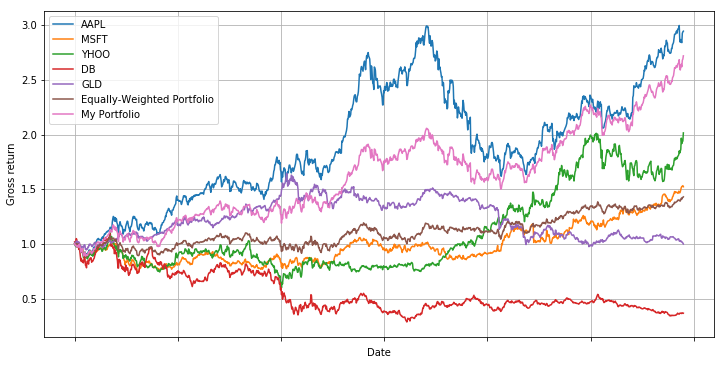

In [75]:
ax = np.cumprod(return_rates + 1).plot.line(grid = True, figsize = (12, 6))
ax.set_ylabel("Gross return")

#### Exercise: Annual Performance Analysis